In [3]:
from zipfile import ZipFile
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from geopandas import GeoDataFrame
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import adjustText as aT
from geopy.distance import geodesic
import pandas as pd
import zipfile
import re
import os 

In [4]:
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Data')

# Loading incident data 
zf = zipfile.ZipFile('Data_incidents.csv.zip') 
df = pd.read_csv('Data_incidents.csv.zip')


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#Extract mass shootings from dataset
mass_shootings = df[df['Mass Shooting']==True].reset_index()

In [6]:
# Loading law data 
df_law = pd.read_csv('gun_law_merge.csv', sep = ';')

# Renaming the state column
df_law.rename(columns={'Unnamed: 0':'state'}, inplace=True)

In [7]:
# Loading map data 
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/maps/states_21basic')

usa = gpd.read_file('states.shp')

### Grouping the incident data by sum and count depending on what we want

In [8]:
#Count incidents per state (True/False values)
df_group_count=df.groupby('state').count().reset_index()
df_group_incidents_count = df_group_count[['state','incident_id']]

# Sum characteristics (number killed/injured etc)
df_group_sum = df.groupby('state').sum().reset_index()
df_group_incidents_sum = df_group_sum[['state','n_killed','n_injured']]


# Dataset with N_incident, n_killed and n_injured
df_group_incidents = df_group_incidents_sum.set_index('state').join(df_group_incidents_count.set_index('state')).reset_index()

### Grouping the incident data by number of true in incident characteristics

In [9]:
df_IC = df.iloc[:, [2] + list(range(19,128))]
df_IC_group = df_IC.groupby('state').sum().reset_index()

### Editing law data

In [10]:
laws =['State permit required to purchase? - Long guns',
'Firearm registration? - Long guns',
'Owner license required? - Long guns',
'Assault weapon law? - Long guns',
'NFA weapons restricted? - Long guns',
'Background checks required for private sales? - Long guns',
'Magazine Capacity Restriction? - Long guns',
'Red flag law? - Long guns',
'State permit required to purchase? - Handguns',
'Firearm registration? - Handguns',
'Owner license required? - Handguns',
'Assault weapon law? - Handguns',
'NFA weapons restricted? - Handguns',
'Background checks required for private sales? - Handguns',
'Magazine Capacity Restriction? - Handguns',
'Red flag law? - Handguns']

laws_longguns = laws[0:8]
laws_handguns = laws[8:16]


#count how many laws on handguns and longgund each state has

df_law['handgun_laws - count'] = df_law.loc[:, laws_handguns].sum(axis=1)
df_law['longgun_laws - count'] = df_law.loc[:, laws_longguns].sum(axis=1)

### Merging the map data, incident data and law data

In [11]:
merged_group = usa.set_index('STATE_NAME').join(df_group_incidents.set_index('state')).reset_index()
merged_group_all = merged_group.set_index('STATE_NAME').join(df_IC_group.set_index('state')).join(df_law.set_index('state'))

# Renaming incident_id to N_incident
merged_group_all.rename(columns={'incident_id':'N_incident'}, inplace=True)

In [12]:
merged_group_all['NFA weapons restricted? - Handguns']
merged_group_all[['N_incident','n_killed', 'n_injured','Child injured','Mass Shooting', 'Child killed self','Hate crime','handgun_laws - count']].describe()

,N_incident,n_killed,n_injured,Child injured,Mass Shooting,Child killed self,Hate crime,handgun_laws - count
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,4725.416667,1169.541667,2329.645833,19.937500,28.166667,3.291667,2.000000,1.895833
std,4169.292020,1191.939577,2488.203825,21.029267,34.211690,4.036843,3.003544,2.442876
min,457.000000,53.000000,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1595.750000,253.750000,638.250000,3.750000,4.000000,0.000000,0.000000,0.000000
50%,3311.500000,798.500000,1387.500000,10.500000,14.000000,1.500000,1.000000,1.000000
75%,6512.250000,1654.000000,3368.000000,34.250000,39.000000,5.250000,2.250000,3.000000
max,16846.000000,5352.000000,13029.000000,72.000000,155.000000,19.000000,15.000000,8.000000


## Plotting point map

### Preparing point data

In [13]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

In [14]:
crs = {'init': 'epsg:4269'}
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

## Plotting Heatmap with points

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


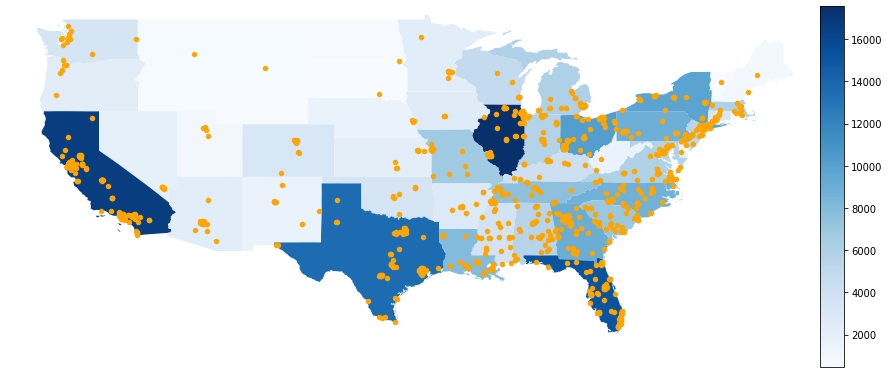

In [19]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'N_incident'

# set the range for the choropleth
vmin, vmax = 472, 17556

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 15))
merged_group_all.plot(column=variable, cmap='Blues', linewidth=0.8, ax = ax)
geo_df[geo_df['Mass Shooting']==True].plot(ax = ax, markersize = 20, color = 'orange', marker = 'o', label = 'Mass Shooting')

plt.xlim(right = -65)
plt.xlim(left = -127)
plt.ylim(bottom = 22.5)
plt.ylim(top = 50)


#Format figure
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.00)

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig.colorbar(sm, cax=cax)

In [18]:
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')

fig.savefig("Incidents_figure.pdf", bbox_inches='tight')

## Plot spatial density map

(-127.0, -65.0, 22.5, 50.0)

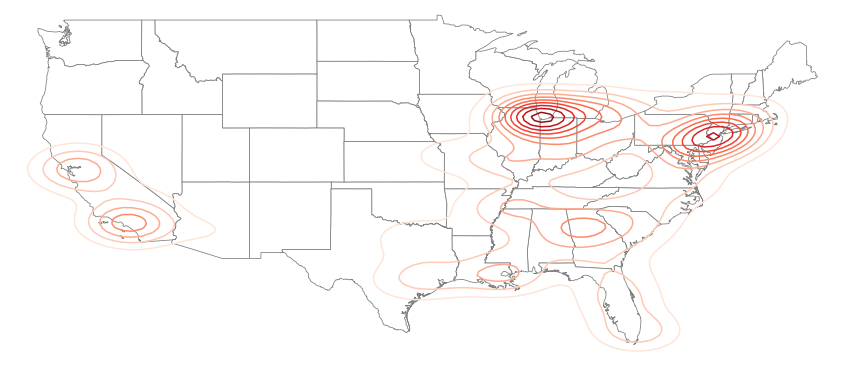

In [20]:
fig_density, ax = plt.subplots(1, figsize=(15, 15))
usa.plot(color='white', edgecolor='grey', linewidth=0.8, ax = ax)
sns.kdeplot(mass_shootings.longitude, mass_shootings.latitude, kernel='biw', cmap = 'Reds', bw='silverman', ax = ax) #shade_lowest=False shade = True,
plt.xlim(right = -65)
plt.xlim(left = -127)
plt.ylim(bottom = 22.5)
plt.ylim(top = 50)
ax.axis('off')

In [21]:
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')

fig_density.savefig("density_mass_shootings.pdf", bbox_inches='tight')

## Population map

In [22]:
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Data')

demo = pd.read_csv('demographics_2018.csv')

In [23]:
usa_demo = usa.set_index('STATE_NAME').join(demo.set_index('NAME')).reset_index()

In [24]:
usa_demo = usa_demo[usa_demo['STATE_NAME']!='Hawaii']
usa_demo = usa_demo[usa_demo['STATE_NAME']!='Alaska']

In [25]:
usa_demo['STATE_NAME'].unique()

array(['Washington', 'Montana', 'Maine', 'North Dakota', 'South Dakota',
       'Wyoming', 'Wisconsin', 'Idaho', 'Vermont', 'Minnesota', 'Oregon',
       'New Hampshire', 'Iowa', 'Massachusetts', 'Nebraska', 'New York',
       'Pennsylvania', 'Connecticut', 'Rhode Island', 'New Jersey',
       'Indiana', 'Nevada', 'Utah', 'California', 'Ohio', 'Illinois',
       'District of Columbia', 'Delaware', 'West Virginia', 'Maryland',
       'Colorado', 'Kentucky', 'Kansas', 'Virginia', 'Missouri',
       'Arizona', 'Oklahoma', 'North Carolina', 'Tennessee', 'Texas',
       'New Mexico', 'Alabama', 'Mississippi', 'Georgia',
       'South Carolina', 'Arkansas', 'Louisiana', 'Florida', 'Michigan'],
      dtype=object)

In [26]:
usa_demo['Total_Pop_mil'] = usa_demo['Total_Pop'].apply(lambda x: x/1000000).round(2)

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


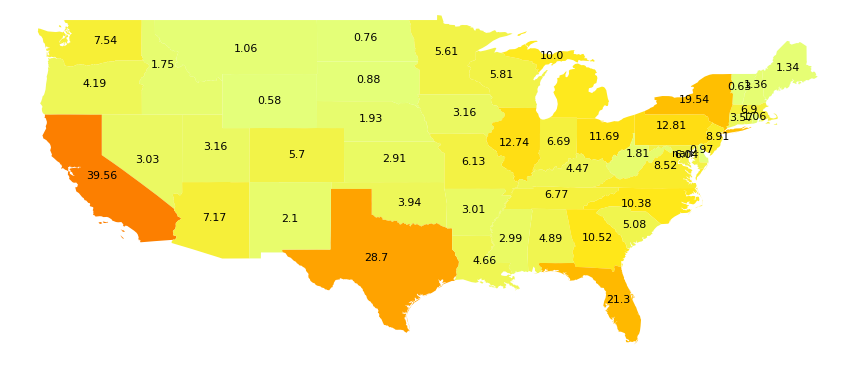

In [27]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Total_Pop'

# set the range for the choropleth
vmin, vmax = 577370, 39557040

# create figure and axes for Matplotlib
fig_pop, ax = plt.subplots(1, figsize=(15, 15))
usa_demo.plot(column = variable, cmap='Wistia', linewidth=0.8, ax = ax)
plt.xlim(right = -65)
plt.xlim(left = -127)
plt.ylim(bottom = 22.5)
plt.ylim(top = 50)
ax.axis('off')


# Add numbers
usa_demo['coords'] = usa_demo['geometry'].apply(lambda x: x.representative_point().coords[:])
usa_demo['coords'] = [coords[0] for coords in usa_demo['coords']]

for idx, row in usa_demo.iterrows():
    plt.annotate(s=row['Total_Pop_mil'], xy=row['coords'],horizontalalignment='center', fontsize = 11)

In [28]:
fig_pop
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')

fig_pop.savefig("population_map.pdf", bbox_inches='tight')

### Law map (Appendix A)

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


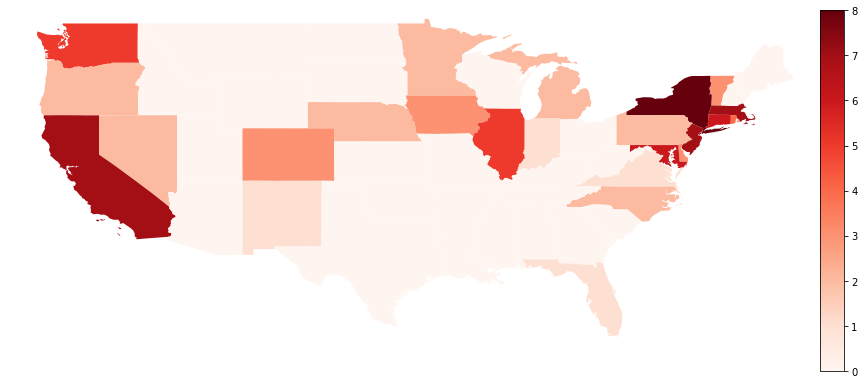

In [29]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'handgun_laws - count'

# set the range for the choropleth
vmin, vmax = 0, 8

# create figure and axes for Matplotlib
fig_law, ax = plt.subplots(1, figsize=(15, 15))
merged_group_all.plot(column=variable, cmap='Reds', linewidth=0.8, ax = ax)
plt.xlim(right = -65)
plt.xlim(left = -127)
plt.ylim(bottom = 22.5)
plt.ylim(top = 50)

#Format plot 
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.00)


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# add the colorbar to the figure
cbar = fig_law.colorbar(sm, cax=cax)

In [30]:
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')

fig_law.savefig("law_map.pdf", bbox_inches='tight')